In [1]:
import sys
sys.path.append('/Users/celiaberon/GitHub/neural-timeseries-analysis/')
from nta.data.simulations import HeadfixedTask
from nta.events import align
from nta.visualization import avg_plots, heatmaps, roc_curves
from nta.events.quantify import group_peak_metrics
from nta.visualization.peak_plots import plot_peaks_wrapper
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

%load_ext autoreload
%autoreload 2

### Simulate behavior and neural data for headfixed task

In [2]:
ntrials = 5000
sim_data = HeadfixedTask()
sim_data.generate_session(total_trials=ntrials)
sim_data.convolve_kernel()

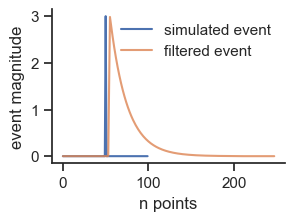

In [3]:
sim_data.plot_event_to_kernel()

### Align neural data to behavior events

In [4]:
trials = sim_data.trials
trials.loc[trials.Reward<0, 'Reward'] = 0
trials['rand_variable'] = np.random.choice(['a','b','c','d'], size=len(trials))
timeseries = sim_data.session
win = (1,3)
ch = ['grnL', 'amplitudes']

for epoch in ['Cue', 'Select', 'Consumption']:
    trials = align.align_photometry_to_event(trials, timeseries, channel=ch,
                                             aligned_event=epoch, window=win, quantify_peaks=True)
        
# Now it's ok to start dropping trials because we've stored photometry snippets.
timeseries_trimmed, trials_trimmed = align.trim_trials_without_licks(timeseries, trials) 

### Plot average and single-trial neural traces aligned to behavior events

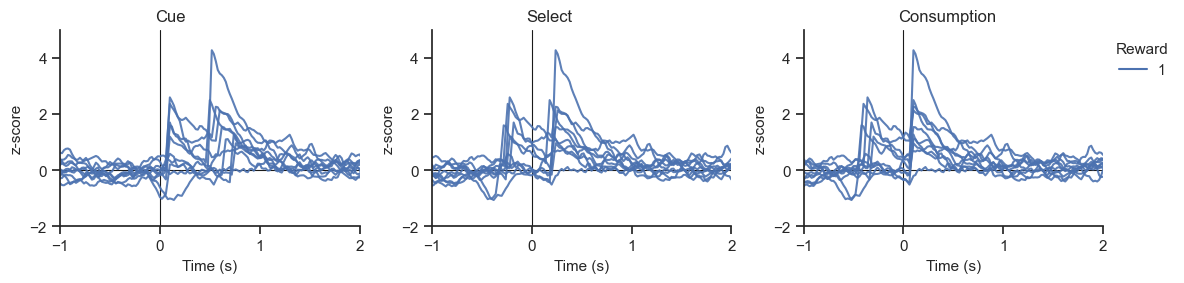

In [5]:
fig, axs = avg_plots.plotting_wrapper(trials_trimmed.sample(n=10),
                                    channel=ch[0],
                                    column='Reward',
                                    window=(1,2),
                                    ylim=(-2,4),
                                    error='se',
                                    trial_units=True)

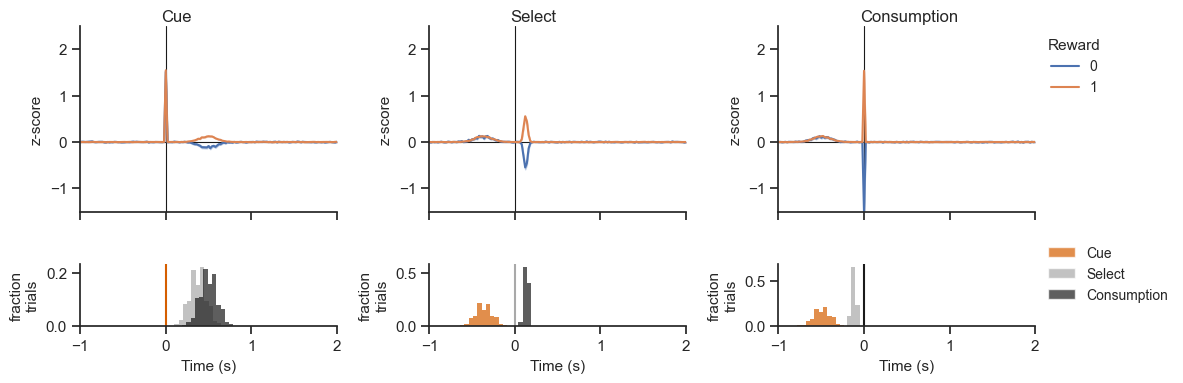

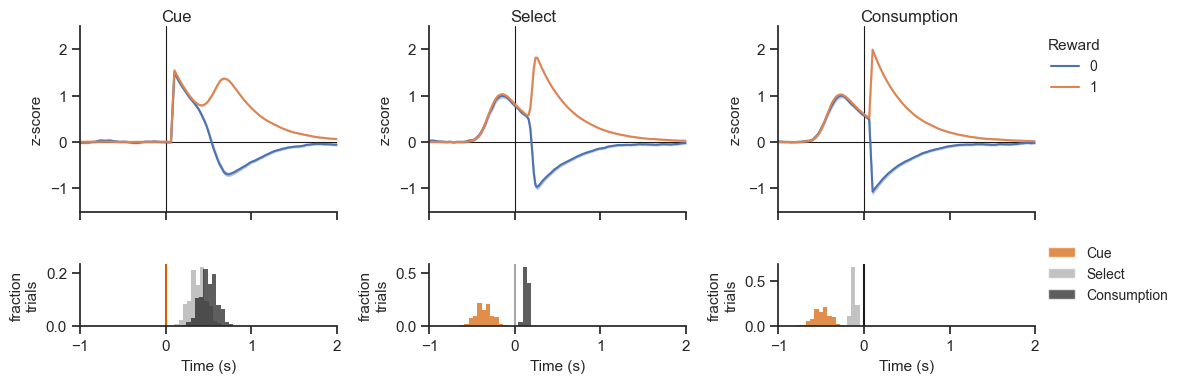

In [8]:
fig, axs = avg_plots.plotting_wrapper(trials_trimmed,
                                   channel=ch[1],
                                   column='Reward',
                                   window=(1,2),
                                   ylim=(-1.5,2.5),
                                   error='se',
                                   behavior_hist=True,
                                   timeseries=timeseries_trimmed)

fig, axs = avg_plots.plotting_wrapper(trials_trimmed,
                                   channel=ch[0],
                                   column='Reward',
                                   window=(1,2),
                                   ylim=(-1.5,2.5),
                                   error='se',
                                   behavior_hist=True,
                                   timeseries=timeseries_trimmed)

### Plot heatmaps where rows represent neural activity across individual trials aligned to task event

/Users/celiaberon/GitHub/neural-timeseries-analysis/nta/visualization/heatmaps.py:521: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


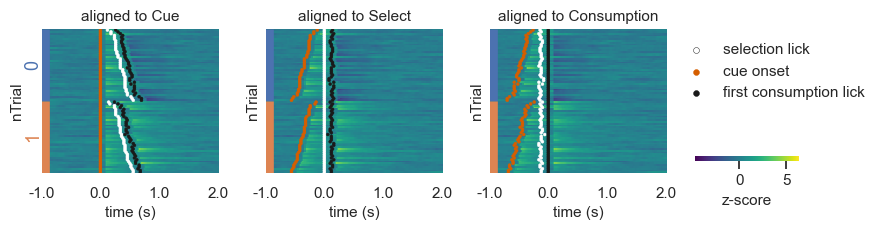

In [46]:
fig, ax = heatmaps.plot_heatmap_wrapper(trials_trimmed, 
                                        alignment_states=['Cue', 'Select', 'Consumption'],
                                        channel=ch[0],
                                        win=(1,2),
                                        # figsize=(10,2),
                                        task_variable='Reward',
                                        subsample=40)

### Simple demo of peak min/max quantification for ground truth testing

Testing peak finding for ground truth:
- max and min for Cue should be (0, 1.5)
- min and max for Consumption should be noisy (-1.5, 1.5), bounded at 0
- Reward dependency of Consumption -- should be 0 opposite reward-evoked valence.

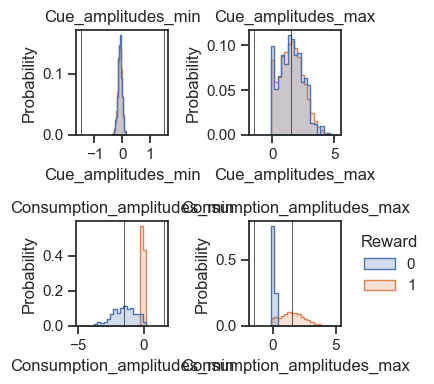

In [23]:
sns.set(style='ticks',
        rc={'axes.labelsize':12, 
            'axes.titlesize':12, 
            'savefig.transparent':True,
            'legend.frameon':False
            })

fig, axs = plt.subplots(2,2, figsize=(5.5,4))
cols = ['Cue_amplitudes_min','Cue_amplitudes_max',
        'Consumption_amplitudes_min', 'Consumption_amplitudes_max']
for legend, (ax, col) in enumerate(zip(axs.flatten(), cols), start=1):
    sns.histplot(data=trials_trimmed, 
                 x=col,
                 ax=ax,
                 hue='Reward',
                 stat='probability',
                 common_norm=False,
                 bins=20,
                 legend=legend==len(cols),
                 element='step')
    ax.axvline(x=1.5, color='k', lw=0.5)
    ax.axvline(x=-1.5, color='k', lw=0.5)
    ax.set(title=col)
legend = ax.get_legend()
legend.set(bbox_to_anchor=(2,1))
plt.tight_layout()

In [12]:
summary = {'max consumption rew': trials_trimmed.query('Reward==1').Consumption_amplitudes_max.mean(),
 'min consumption rew': trials_trimmed.query('Reward==1').Consumption_amplitudes_min.mean(),
 'max consumption NR': trials_trimmed.query('Reward==0').Consumption_amplitudes_max.mean(),
 'min consumption NR': trials_trimmed.query('Reward==0').Consumption_amplitudes_min.mean(),
 'max cue rew': trials_trimmed.query('Reward==1').Cue_amplitudes_max.mean(),
 'min cue rew': trials_trimmed.query('Reward==1').Cue_amplitudes_min.mean(),
 'max cue NR': trials_trimmed.query('Reward==0').Cue_amplitudes_max.mean(),
 'min cue NR': trials_trimmed.query('Reward==0').Cue_amplitudes_min.mean()}

for k, v in summary.items():
    print(f'{k}: {round(v, 2)}')

max consumption rew: 1.54
min consumption rew: -0.09
max consumption NR: 0.09
min consumption NR: -1.54
max cue rew: 1.56
min cue rew: -0.09
max cue NR: 1.52
min cue NR: -0.09


### Test timing detection
"Neural events" are created at the time of behavior/task events and filtered with same distribution, so timing should be precise for both `amplitudes` (0), and `z` channel (lagged).

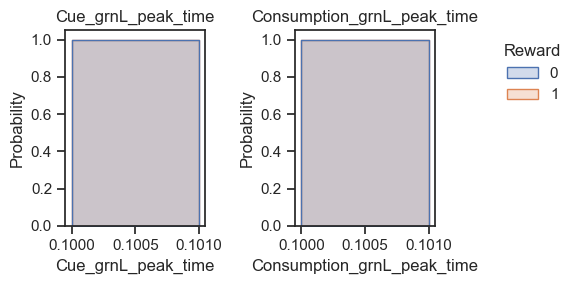

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(7,3))
cols = ['Cue_grnL_peak_time','Consumption_grnL_peak_time',]
for legend, (ax, col) in enumerate(zip(axs, cols), start=1):
    sns.histplot(data=trials_trimmed, 
                 x=col,
                 ax=ax,
                 hue='Reward',
                 stat='probability',
                 common_norm=False,
                 binwidth=0.001,
                 legend=legend==len(cols),
                 element='step')
    ax.set(title=col)
legend = ax.get_legend()
legend.set(bbox_to_anchor=(2,1))
plt.tight_layout()

### Example: Barplot with default layout, setting a palette.

defaulting to autofit axis limits


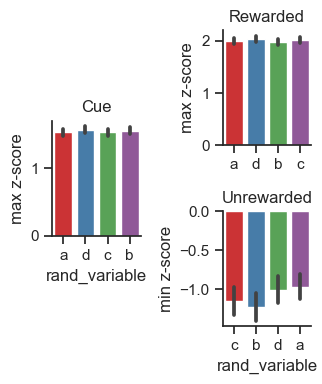

In [14]:
fig, ax = plot_peaks_wrapper(trials_trimmed, 
                             x_col='rand_variable',
                             channel=ch[0],
                             plot_func=sns.barplot,
                             plot_func_kws={'palette':'Set1'},
                             metrics={'Cue':'max', 'reward':'max', 'no reward':'min'},
                            )

### Example: point plot with flattened layout of standard state set, plotting min values for all states.

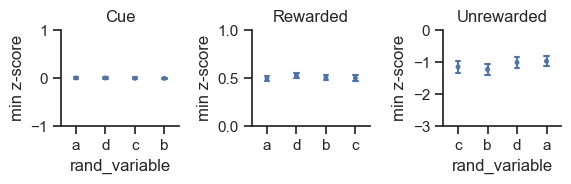

In [15]:
pointplot_kws = {'scale':0.4, 'errorbar':'ci', 'palette':None, 'capsize':0.15, 'errwidth':1.5,'join':False}

fig, ax = plot_peaks_wrapper(trials_trimmed, 
                             x_col='rand_variable',
                             channel=ch[0],
                             plot_func=sns.pointplot,
                             plot_func_kws=pointplot_kws,
                             metrics='min',
                             flatten_layout=True,
                             axes_style={'Cue':(-1,1), 'reward':(0,1), 'no reward':(-3,0)}
                            )

### Example: violinplots with and without outliers dropped

defaulting to autofit axis limits
defaulting to autofit axis limits
0.006 points removed as outliers
0.009 points removed as outliers
0.005 points removed as outliers
0.004 points removed as outliers
0.054 points removed as outliers
0.072 points removed as outliers
0.065 points removed as outliers
0.056 points removed as outliers


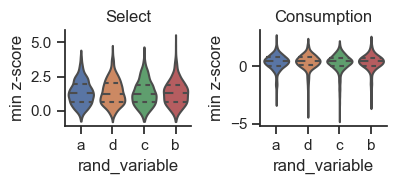

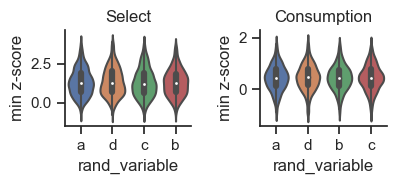

In [16]:
peaks = group_peak_metrics(trials_trimmed, 
                         grouping_levels=['Reward'],
                         channel=ch[0],
                         agg_funcs=['max', 'min'],
                         states=['Select', 'Consumption'],
                         offset=False)

violinplot_kws = {'palette':None, 'cut':0, 'inner':'quartiles'}
fig, ax = plot_peaks_wrapper(peaks, 
                           x_col='rand_variable',
                           channel=ch[0],
                           plot_func=sns.violinplot,
                           metrics='min',
                           flatten_layout=True,
                           plot_func_kws=violinplot_kws,
                           states=['Select', 'Consumption'], ignore_reward=True
                            )

fig, ax = plot_peaks_wrapper(peaks, 
                            x_col='rand_variable',
                            channel=ch[0],
                            plot_func=sns.violinplot,
                            metrics='min',
                            flatten_layout=True,
                            states=['Select', 'Consumption'], ignore_reward=True,
                            show_outliers=False
                            )

## Validate negative control
Should have no discriminability when "behavioral variable" value does not depend at all on magnitude of measured "neural signaL" (i.e., null hypothesis)

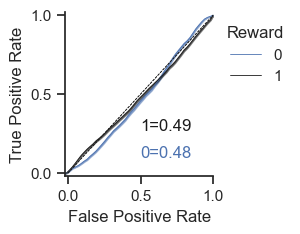

In [17]:
trials['rand_binary_variable'] = np.random.choice([0,1], size=len(trials))
ax_test = roc_curves.multiclass_roc_curves(trials=trials,
                                           pred_behavior='rand_binary_variable',
                                           neural_event='Consumption_grnL_mean',
                                           palette={0:sns.color_palette()[0]},
                                           n_samples=100)

### Validate on positive control
Should have perfect discriminability when "behavioral variable" value depends directly on magnitude of measured "neural signal"

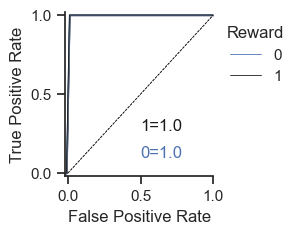

In [19]:
trials['thresh_binary_variable'] = (trials['Consumption_grnL_mean'] > 0).astype('int')
ax_test = roc_curves.multiclass_roc_curves(trials=trials,
                                           pred_behavior='thresh_binary_variable',
                                           neural_event='Consumption_grnL_mean',
                                           palette={0:sns.color_palette()[0]},
                                           n_samples=10)